# Содержание

>[Содержание](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=-Jj_CzxbKo5g)

>[Домашнее задание](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=tSZpGwrXKW2p)

>>[1 Импорт необходимых библиотек](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=_xB6QpAv31l-)

>>[2 Определение функций и классов для работы с датасетом](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=YXCC99c239GX)

>>[3 Подключение к диску](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=UTVBYW2QI0f4)

>>[4 Определение путей к каталогам, распаковка датасета](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=8VElDzffI9Pg)

>>[5 Определение рабочего и тестового датасета](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=wthZemm5JIRL)

>>[6 Разделение рабочего датасета на тренировочный и валидационный](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=h8hpQj1SJPkR)

>>[7 Предобработка данных](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=A8EUuRxSJci6)

>>[8 Запись датасета в собственный класс и в Dataloader](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=W-jw1u1IJpdY)

>>[9 Определение модели](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=Caeh9bXCJ0Wl)

>>[10 Определение оптимизатора и функции потерь](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=PBZ8MnfIJ5xi)

>>[11 Обучение модели](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=Wds5o8bWKB4C)

>>[12 Визуализация зависимости функции потерь на тренировочный и тестовых данных](#updateTitle=true&folderId=1_EX6Wdm7f9wyO-efHmDSQkaMo_ftagfi&scrollTo=Ro8iJKYCKGZU)



# Домашнее задание

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?


## 1 Импорт необходимых библиотек

In [99]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32896 sha256=00c51049a22446796246d3aae0c4328ef3b2be2651e531c4518171e4f5886267
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


In [163]:
import os
import wget
import shutil
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np
import seaborn as sns
from google.colab import drive, files
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [155]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2 Определение функций и классов для работы с датасетом

In [192]:
def makeDir(dir_name):
    """Функция для создания папки/каталога/директории"""
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

"""Определение стоп слов из языка lang('ru', 'en', etc.)"""
sw = set(get_stop_words(language='en'))

"""Определение пунктуационных знаков"""
puncts = set(punctuation)

"""Приведение слова к правильной форме"""
morpher = MorphAnalyzer()


def my_preprocessing(txt):
    """Функция для предварительной подготовки данных"""

    """Предварительная обработка"""
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("no\s", "no", txt)

    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]

    return " ".join(txt)

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding


class Model_Text(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.dp1 = nn.Dropout(0.4)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.dp2 = nn.Dropout(0.3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.dp3 = nn.Dropout(0.2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x) # B, L, E
        #                       B  E  L
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.dp1(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.dp2(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.dp3(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output


class MyTextData(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

## 3 Подключение к диску

In [5]:
drive.mount("/content/drive/")

Mounted at /content/drive/


## 4 Определение путей к каталогам, распаковка датасета

In [10]:
path_dir = "/content/drive/MyDrive/"

In [13]:
work_dir = path_dir + "Twit/"

In [48]:
# makeDir(work_dir)

In [50]:
# !unzip "/content/drive/MyDrive/Twit/twit.zip" -d "/content/drive/MyDrive/Twit/"

Archive:  /content/drive/MyDrive/Twit/twit.zip
  inflating: /content/drive/MyDrive/Twit/test.csv  
  inflating: /content/drive/MyDrive/Twit/train.csv  


In [51]:
os.listdir(work_dir)

['.ipynb_checkpoints', 'twit.zip', 'test.csv', 'train.csv']

## 5 Определение рабочего и тестового датасета

In [142]:
df_train = pd.read_csv(work_dir + "train.csv")
df_test = pd.read_csv(work_dir + "test.csv")

In [143]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [144]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## 6 Разделение рабочего датасета на тренировочный и валидационный

In [145]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=13)

## 7 Предобработка данных

In [146]:
tqdm.pandas()
df_train['tweet'] = df_train['tweet'].progress_apply(my_preprocessing)
df_val['tweet'] = df_val['tweet'].progress_apply(my_preprocessing)
df_test['tweet'] = df_test['tweet'].progress_apply(my_preprocessing)

100%|██████████| 17197/17197 [00:06<00:00, 2725.74it/s]


In [148]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [149]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [150]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [169]:
max_words = 5000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
len(tokens_filtered_top)

4999

In [170]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [171]:
max_len = 15
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train['tweet']])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val['tweet']])

## 8 Запись датасета в собственный класс и в Dataloader

In [172]:
batch_size = 1024
train_dataset = MyTextData(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyTextData(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## 9 Определение модели

In [205]:
model = Model_Text(vocab_size=max_words)

In [206]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Model_Text(
  (embedding): Embedding(5000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (dp1): Dropout(p=0.4, inplace=False)
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (dp2): Dropout(p=0.3, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (dp3): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 730497


## 10 Определение оптимизатора и функции потерь

In [207]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

## 11 Обучение модели

In [208]:
epochs = 20
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/20]. Step [24/24]. Loss: 0.234. Acc: 0.916. Test loss: 0.165. Test acc: 0.934
Epoch [2/20]. Step [24/24]. Loss: 0.254. Acc: 0.928. Test loss: 0.553. Test acc: 0.934
Epoch [3/20]. Step [24/24]. Loss: 0.173. Acc: 0.928. Test loss: 0.090. Test acc: 0.934
Epoch [4/20]. Step [24/24]. Loss: 0.232. Acc: 0.928. Test loss: 0.163. Test acc: 0.934
Epoch [5/20]. Step [24/24]. Loss: 0.138. Acc: 0.928. Test loss: 0.092. Test acc: 0.934
Epoch [6/20]. Step [24/24]. Loss: 0.146. Acc: 0.932. Test loss: 0.287. Test acc: 0.943
Epoch [7/20]. Step [24/24]. Loss: 0.162. Acc: 0.949. Test loss: 0.634. Test acc: 0.948
Epoch [8/20]. Step [24/24]. Loss: 0.126. Acc: 0.957. Test loss: 0.056. Test acc: 0.949
Epoch [9/20]. Step [24/24]. Loss: 0.109. Acc: 0.962. Test loss: 0.628. Test acc: 0.951
Epoch [10/20]. Step [24/24]. Loss: 0.097. Acc: 0.967. Test loss: 0.013. Test acc: 0.953
Epoch [11/20]. Step [24/24]. Loss: 0.068. Acc: 0.972. Test loss: 0.456. Test acc: 0.954
Epoch [12/20]. Step [24/24]. Loss: 0.096.

## 12 Визуализация зависимости функции потерь на тренировочный и тестовых данных

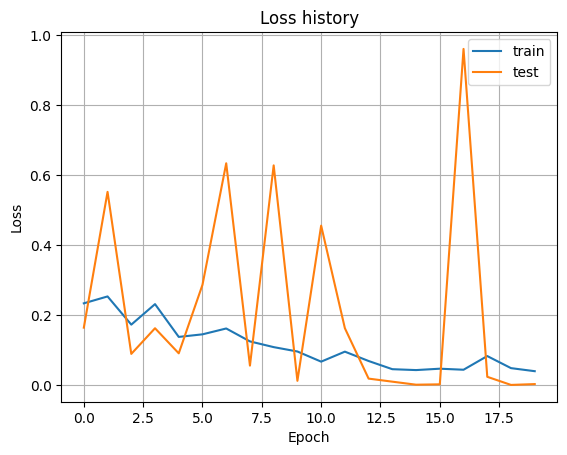

In [209]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()